In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

## Visualize DM mass distribution

In [ ]:
from swiftsimio import load
from swiftsimio.visualisation.projection import project_pixel_grid
from swiftsimio.visualisation.smoothing_length_generation import generate_smoothing_lengths

data = load('/home/fabian/ownCloud/sim_data/snapshot_0036.hdf5')

# Generate smoothing lengths for the dark matter
data.dark_matter.smoothing_length = generate_smoothing_lengths(
    data.dark_matter.coordinates,
    data.metadata.boxsize,
    kernel_gamma=1.8,
    neighbours=57,
    speedup_fac=2,
    dimension=3,
)

# Project the dark matter mass
dm_mass = project_pixel_grid(
    # Notice here that we pass in the dark matter dataset not the whole
    # data object, to specify what particle type we wish to visualise
    data=data.dark_matter,
    boxsize=data.metadata.boxsize,
    resolution=1024,
    project="masses",
    parallel=True,
    region=None
)

In [ ]:
from matplotlib.pyplot import imsave
from matplotlib.colors import LogNorm

# Everyone knows that dark matter is purple
imsave("sim_data/dm_mass_map.png", LogNorm()(dm_mass), cmap="inferno")

## Calculate halo mass function (HMF)

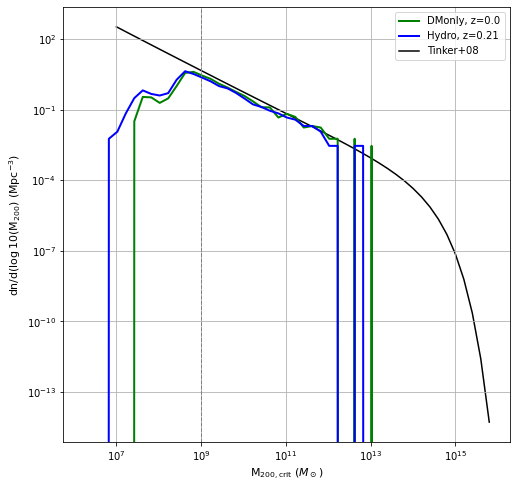

In [3]:
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18');
from colossus.lss import mass_function

def HMF(subhalo_properties, snapshot):

    dlogm = 0.2
    bins = 10 ** (np.arange(6, 15, dlogm))
    V = 12 ** 3 # Mpc

    # Load the data
    g = h5py.File(subhalo_properties, 'r')
    mass = g["Mass_200crit"][:] * 1e10  # convert to Msun

    binnedmass, massrange = np.histogram(mass, bins=bins)

    # Sums all halos with mass greater than a mass of bin range
    massnlarger = np.zeros(len(binnedmass))
    for i in range(0, len(massnlarger)):
        massnlarger[i] = np.sum(binnedmass[i:])

    f = h5py.File(snapshot, 'r')
    cosmo = f["Cosmology"]
    redshift = cosmo.attrs["Redshift"][0]
    mass = f["PartType1/Masses"][:]
    mass = mass[0] * 1e10 # convert to Msun
    limit = 100 * mass

    # --------------------------------------------------------------------------
    ### Determine the HMF

    errormassn = massnlarger ** 0.5
    numbden = massnlarger / V
    numbdenerr = errormassn / V
    massplot = (massrange[:-1] + massrange[1:]) / 2

    # Determine amount of halos in each bin and divide by binsize
    dernumbden = -np.diff(numbden) / np.diff(np.log10(massplot))

    dererr = 2 ** 0.5 / dlogm * (numbdenerr[:-1] + numbdenerr[1:]) / 2

    # To plot amount of halos in each bin, calculate middle of these bins
    M = (massplot[:-1] + massplot[1:]) / 2.
    
    # Renaming
    dndM = dernumbden
    error = dererr
    # --------------------------------------------------------------------------

    return M, dndM, error, limit, redshift


def make_HMF():

    # Different version of L012N0188.

    subhalo_files = [
    '/home/fabian/ownCloud/sim_data/subhalo_0036.properties',  # DMonly
    '/home/fabian/ownCloud/sim_data/subhalo_0033.properties'  # Hydro
    ]

    snapshot_files = [
        '/home/fabian/ownCloud/sim_data/snapshot_0036.hdf5',  # DMonly
        '/home/fabian/ownCloud/sim_data/snapshot_0033.hdf5'  # Hydro
    ]

    plt.figure(figsize=(8,8))

    for sub_f, snap_f in zip(subhalo_files, snapshot_files):

        # Get HMF from sim.
        M, dndM, error, limit, redshift = HMF(sub_f, snap_f)

        redshift = np.round(redshift, 2)

        # Split input string for later use.
        snap = re.split('.hdf5', re.split('/', snap_f)[-1])[0]
        if snap == 'snapshot_0036':
            sim_label = f'DMonly, z={redshift}'
            sim_col = 'green'
        else:
            sim_label = f'Hydro, z={redshift}'
            sim_col = 'blue'        


        # Plot HMF from sim.
        plt.loglog(M, dndM, label=sim_label,lw=2,color=sim_col)
        # plt.fill_between(M, dndM - error, dndM + error, alpha=0.4,color='tab:green')

        h = 0.67
        M = 10 ** np.arange(7, 16, 0.2)

    # Plot HMF from Tinker et al. (2008).
    mfunc = mass_function.massFunction(
        M / h, redshift, mdef='200c', model='tinker08', q_out='dndlnM'
        )
    plt.loglog(M, mfunc / h**3, '-', label='Tinker+08', color='black', zorder=1)


    # Halos with DM particles below limit (100) are numerically unreliable.
    plt.axvline(x=limit, linestyle="--", lw=1, color="grey")

    plt.xlabel("M${}_{200,\mathrm{crit}}$ ($M_\odot$)")
    plt.ylabel("dn/d($\log$10(M${}_{200}$) (Mpc$^{-3}$)")
    plt.legend(loc='upper right' ,prop={'size': 10})
    plt.grid("True")
    plt.savefig(f'sim_data/HMFs_L012N0188.pdf', bbox_inches='tight')#, dpi=200)
    plt.show()


make_HMF()